In [1]:
# Importing the modules and libraries
# Additional libraries should be imported in this cell for organization

from datetime import datetime
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import matplotlib.dates as mdates
import pandas as pd
from pandas.plotting import autocorrelation_plot
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import pmdarima as pm
from pmdarima.arima import ADFTest
from dateutil.relativedelta import relativedelta, MO
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
# fix random seed for reproducibility
tf.random.set_seed(7)

# Purpose of the Test
The purpose of this test is to compare the LSTM and ARIMA models' performances and accuracy on predicting data. <br>
The data used for this purpose is an hourly data of solar radiation for the city centre of Compiégne which contains hourly data on photovoltaic energy, <br>
global horizontal irradiance, 2 meter temperature, etc.


In [3]:
# Reading the datasets and creating the dataframes

dataset = pd.read_csv("Compiegne_Solar_2021.csv", skiprows=10, skipfooter=10, engine='python')
df_2021 = pd.DataFrame(dataset)

dataset = pd.read_csv("Compiegne_Solar_2022.csv", skiprows=10, skipfooter=10, engine='python')
df_2022 = pd.DataFrame(dataset)

dataset = pd.read_csv("Compiegne_Solar_2023.csv", skiprows=10, skipfooter=10, engine='python')
df_2023 = pd.DataFrame(dataset)

print(df_2021.head())
print(df_2022.head())
print(df_2022.head())

            time    P  G(i)  H_sun   T2m  WS10m  Int
0  20210101:0010  0.0   0.0    0.0 -0.21   1.59  0.0
1  20210101:0110  0.0   0.0    0.0 -0.44   1.59  0.0
2  20210101:0210  0.0   0.0    0.0 -0.48   1.38  0.0
3  20210101:0310  0.0   0.0    0.0 -0.47   1.24  0.0
4  20210101:0410  0.0   0.0    0.0 -0.50   1.24  0.0
            time    P  G(i)  H_sun    T2m  WS10m  Int
0  20220101:0010  0.0   0.0    0.0  10.99   2.55  0.0
1  20220101:0110  0.0   0.0    0.0  11.01   2.41  0.0
2  20220101:0210  0.0   0.0    0.0  11.09   2.21  0.0
3  20220101:0310  0.0   0.0    0.0  11.05   2.14  0.0
4  20220101:0410  0.0   0.0    0.0  10.80   2.34  0.0
            time    P  G(i)  H_sun    T2m  WS10m  Int
0  20220101:0010  0.0   0.0    0.0  10.99   2.55  0.0
1  20220101:0110  0.0   0.0    0.0  11.01   2.41  0.0
2  20220101:0210  0.0   0.0    0.0  11.09   2.21  0.0
3  20220101:0310  0.0   0.0    0.0  11.05   2.14  0.0
4  20220101:0410  0.0   0.0    0.0  10.80   2.34  0.0


In [4]:
print(df_2021.tail())
print(df_2022.tail())
print(df_2022.tail())

               time    P  G(i)  H_sun    T2m  WS10m  Int
8755  20211231:1910  0.0   0.0    0.0  10.89   3.17  0.0
8756  20211231:2010  0.0   0.0    0.0  10.66   3.93  0.0
8757  20211231:2110  0.0   0.0    0.0  10.60   3.93  0.0
8758  20211231:2210  0.0   0.0    0.0  10.57   3.10  0.0
8759  20211231:2310  0.0   0.0    0.0  10.63   2.62  0.0
               time    P  G(i)  H_sun    T2m  WS10m  Int
8755  20221231:1910  0.0   0.0    0.0  14.96   7.66  0.0
8756  20221231:2010  0.0   0.0    0.0  14.90   7.52  0.0
8757  20221231:2110  0.0   0.0    0.0  14.84   7.45  0.0
8758  20221231:2210  0.0   0.0    0.0  14.84   7.66  0.0
8759  20221231:2310  0.0   0.0    0.0  14.71   7.86  0.0
               time    P  G(i)  H_sun    T2m  WS10m  Int
8755  20221231:1910  0.0   0.0    0.0  14.96   7.66  0.0
8756  20221231:2010  0.0   0.0    0.0  14.90   7.52  0.0
8757  20221231:2110  0.0   0.0    0.0  14.84   7.45  0.0
8758  20221231:2210  0.0   0.0    0.0  14.84   7.66  0.0
8759  20221231:2310  0.0   0.0 

# Explanations of the Variables
<b>P:</b> PV system power (W) <br>
<b>G(i):</b> Global irradiance on the inclined plane (plane of the array) (W/m2) <br>
<b>H_sun:</b> Sun height (degree) <br>
<b>T2m:</b> 2-m air temperature (degree Celsius) <br>
<b>WS10m:</b> 10-m total wind speed (m/s) <br>
<b>Int:</b> 1 means solar radiation values are reconstructed

The time will mostly be irrelevant for our studies since the models can understand the datasets as sequential, but modifying the time data <br>
and changing it to a Datetime object is nevertheless good practice.

In [5]:
df_2021['time'] = pd.to_datetime(df_2021['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
df_2021 = df_2021.set_index(['time'])

df_2022['time'] = pd.to_datetime(df_2022['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
df_2022 = df_2022.set_index(['time'])

df_2023['time'] = pd.to_datetime(df_2023['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
df_2023 = df_2023.set_index(['time'])

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_14840\2361934584.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_2021['time'] = pd.to_datetime(df_2021['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_14840\2361934584.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_2022['time'] = pd.to_datetime(df_2022['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_14840\2361934584.py:7: UserWarning: The argume

In [6]:
df_2021

P  G(i)  H_sun    T2m  WS10m  Int
time                                                    
2021-01-01 00:10:00  0.0   0.0    0.0  -0.21   1.59  0.0
2021-01-01 01:10:00  0.0   0.0    0.0  -0.44   1.59  0.0
2021-01-01 02:10:00  0.0   0.0    0.0  -0.48   1.38  0.0
2021-01-01 03:10:00  0.0   0.0    0.0  -0.47   1.24  0.0
2021-01-01 04:10:00  0.0   0.0    0.0  -0.50   1.24  0.0
...                  ...   ...    ...    ...    ...  ...
2021-12-31 19:10:00  0.0   0.0    0.0  10.89   3.17  0.0
2021-12-31 20:10:00  0.0   0.0    0.0  10.66   3.93  0.0
2021-12-31 21:10:00  0.0   0.0    0.0  10.60   3.93  0.0
2021-12-31 22:10:00  0.0   0.0    0.0  10.57   3.10  0.0
2021-12-31 23:10:00  0.0   0.0    0.0  10.63   2.62  0.0

[8760 rows x 6 columns]

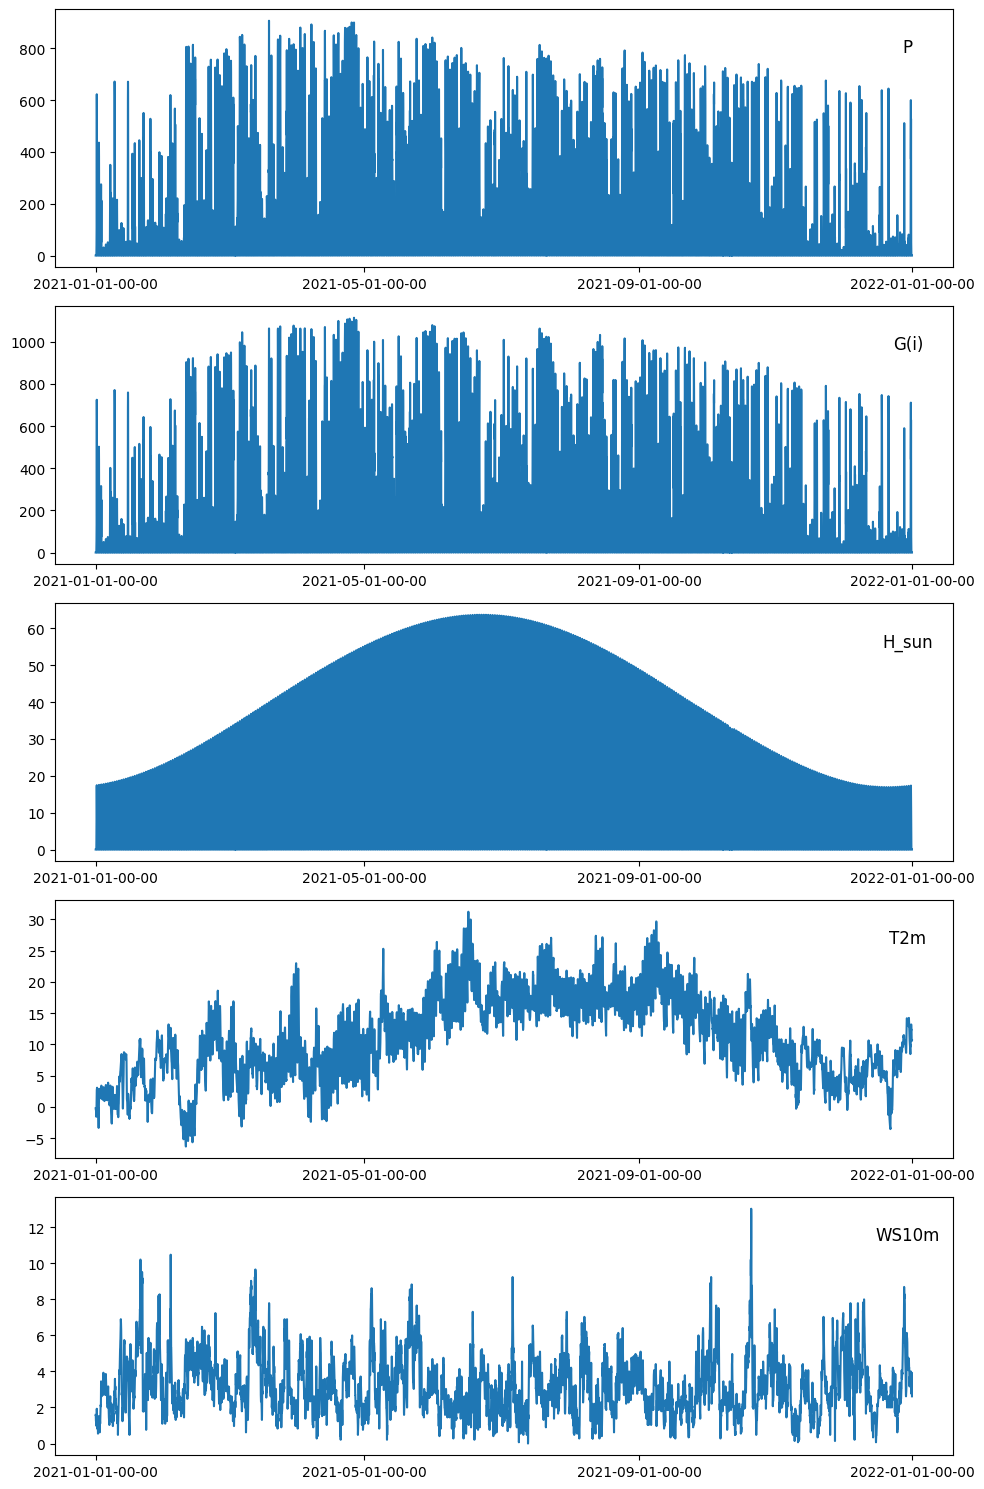

In [7]:
# Creating separate subplots for each series
values = df_2021.values
dates = df_2021.index  # Get the datetime index

# Specify columns to plot
groups = [0, 1, 2, 3, 4]  # The 'Int' column always has the value 0, so it is negatable
i = 1

plt.figure(figsize=(10, 15))

for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates, values[:, group])  # Use datetime index on x-axis
    plt.title(df_2021.columns[group], y=0.8, x=0.95)

    # Set major x-axis locator to show only 4 dates
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=5))  # Force 4 labels
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d-%H-%M'))  # Format as 'YYYY-MM-DD-HH-mm'

    i += 1

plt.tight_layout()
plt.show()

# Training the LSTM Model (Temperature Prediction)
The LSTM model will be trained on data from 2021 and 2022, and tested on data from 2023.

In [8]:
frames_to_concat = [df_2021, df_2022]

df_2021_2022 = pd.concat(frames_to_concat)

In [9]:
df_2021_2022

P  G(i)  H_sun    T2m  WS10m  Int
time                                                    
2021-01-01 00:10:00  0.0   0.0    0.0  -0.21   1.59  0.0
2021-01-01 01:10:00  0.0   0.0    0.0  -0.44   1.59  0.0
2021-01-01 02:10:00  0.0   0.0    0.0  -0.48   1.38  0.0
2021-01-01 03:10:00  0.0   0.0    0.0  -0.47   1.24  0.0
2021-01-01 04:10:00  0.0   0.0    0.0  -0.50   1.24  0.0
...                  ...   ...    ...    ...    ...  ...
2022-12-31 19:10:00  0.0   0.0    0.0  14.96   7.66  0.0
2022-12-31 20:10:00  0.0   0.0    0.0  14.90   7.52  0.0
2022-12-31 21:10:00  0.0   0.0    0.0  14.84   7.45  0.0
2022-12-31 22:10:00  0.0   0.0    0.0  14.84   7.66  0.0
2022-12-31 23:10:00  0.0   0.0    0.0  14.71   7.86  0.0

[17520 rows x 6 columns]

In [10]:
df_2021_2022_Temp = df_2021_2022.iloc[:, [3]]

print(df_2021_2022_Temp.head())

df_2023_Temp = df_2023.iloc[:, [3]]

print(df_2023_Temp.head())

                      T2m
time                     
2021-01-01 00:10:00 -0.21
2021-01-01 01:10:00 -0.44
2021-01-01 02:10:00 -0.48
2021-01-01 03:10:00 -0.47
2021-01-01 04:10:00 -0.50
                       T2m
time                      
2023-01-01 00:10:00  14.72
2023-01-01 01:10:00  14.59
2023-01-01 02:10:00  14.47
2023-01-01 03:10:00  14.50
2023-01-01 04:10:00  14.21


In [22]:
# Preparing dataset for LSTM training

df_lstm_training = df_2021_2022_Temp.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = df_2023_Temp.values
df_lstm_testing = df_lstm_testing.astype('float32')

In [23]:
# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

In [19]:
# Convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [24]:
# Reshape into X=t and Y=t+1

look_back = 10 # Predicting the next value based on how many previous values
trainX, trainY = create_dataset(df_lstm_training, look_back)
testX, testY = create_dataset(df_lstm_testing, look_back)

In [25]:
# Reshape input to be [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [26]:
np.shape(trainX)

(17509, 1, 10)

In [27]:
# Create and fit the LSTM network

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=300, batch_size=6, verbose=2)

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
2919/2919 - 15s - 5ms/step - loss: 0.0040
Epoch 2/300
2919/2919 - 7s - 2ms/step - loss: 4.2409e-04
Epoch 3/300
2919/2919 - 7s - 2ms/step - loss: 3.1499e-04
Epoch 4/300
2919/2919 - 7s - 2ms/step - loss: 2.4555e-04
Epoch 5/300
2919/2919 - 7s - 2ms/step - loss: 2.0354e-04
Epoch 6/300
2919/2919 - 7s - 2ms/step - loss: 1.8102e-04
Epoch 7/300
2919/2919 - 7s - 3ms/step - loss: 1.6977e-04
Epoch 8/300
2919/2919 - 7s - 2ms/step - loss: 1.6385e-04
Epoch 9/300
2919/2919 - 7s - 2ms/step - loss: 1.6029e-04
Epoch 10/300
2919/2919 - 7s - 2ms/step - loss: 1.5782e-04
Epoch 11/300
2919/2919 - 7s - 2ms/step - loss: 1.5591e-04
Epoch 12/300
2919/2919 - 7s - 2ms/step - loss: 1.5433e-04
Epoch 13/300
2919/2919 - 7s - 3ms/step - loss: 1.5297e-04
Epoch 14/300
2919/2919 - 7s - 2ms/step - loss: 1.5176e-04
Epoch 15/300
2919/2919 - 9s - 3ms/step - loss: 1.5067e-04
Epoch 16/300
2919/2919 - 7s - 3ms/step - loss: 1.4967e-04
Epoch 17/300
2919/2919 - 7s - 3ms/step - loss: 1.4876e-04
Epoch 18/300
2919/2919 - 7

In [28]:
# Make predictions

trainPredict_LSTM = model.predict(trainX)
testPredict_LSTM = model.predict(testX)

# Invert predictions

trainPredict_LSTM = scaler.inverse_transform(trainPredict_LSTM)
trainY = scaler.inverse_transform([trainY])
testPredict_LSTM = scaler.inverse_transform(testPredict_LSTM)
testY = scaler.inverse_transform([testY])

# Calculate overall root mean squared error

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict_LSTM[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict_LSTM[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train Score: 0.40 RMSE
Test Score: 0.43 RMSE


In [30]:
# Compute per-prediction RMSE (not aggregated)
trainRMSE_each = np.sqrt((trainPredict_LSTM[:,0] - trainY[0]) ** 2)
testRMSE_each = np.sqrt((testPredict_LSTM[:,0] - testY[0]) ** 2)

# Round RMSE values to 3 decimal places
trainRMSE_each = np.round(trainRMSE_each, 3)
testRMSE_each = np.round(testRMSE_each, 3)

# Print first 10 RMSE values as an example
print("First 10 Train RMSE values:", trainRMSE_each[:10])
print("First 10 Test RMSE values:", testRMSE_each[:10])

First 10 Train RMSE values: [0.019 0.132 0.226 0.086 0.061 0.086 0.26  0.192 0.114 1.605]
First 10 Test RMSE values: [1.000e-03 5.800e-02 1.270e-01 5.350e-01 1.330e-01 4.600e-02 3.490e-01
 3.000e-02 4.000e-03 1.067e+00]


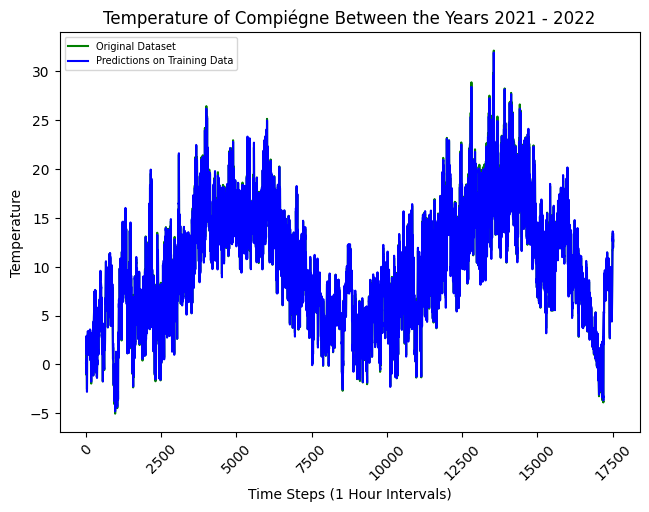

In [33]:
# Shift train predictions for plotting

trainPredictPlot = np.empty_like(df_lstm_training)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict_LSTM)+look_back, :] = trainPredict_LSTM

# Plot baseline and predictions

plt.plot(scaler.inverse_transform(df_lstm_training), 'g', label='Original Dataset')
plt.plot(trainPredictPlot, 'b', label='Predictions on Training Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne Between the Years 2021 - 2022')
plt.show()

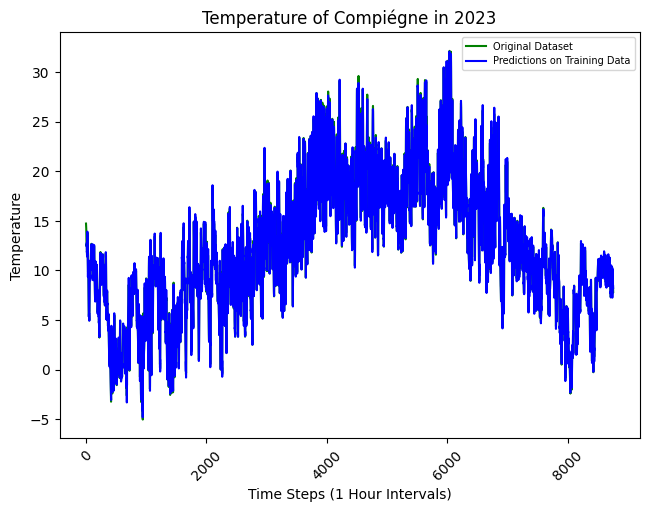

In [34]:
# Shift train predictions for plotting

testPredictPlot = np.empty_like(df_lstm_testing)
testPredictPlot[:, :] = np.nan
testPredictPlot[look_back:len(testPredict_LSTM)+look_back, :] = testPredict_LSTM

# Plot baseline and predictions

plt.plot(scaler.inverse_transform(df_lstm_testing), 'g', label='Original Dataset')
plt.plot(testPredictPlot, 'b', label='Predictions on Training Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023')
plt.show()

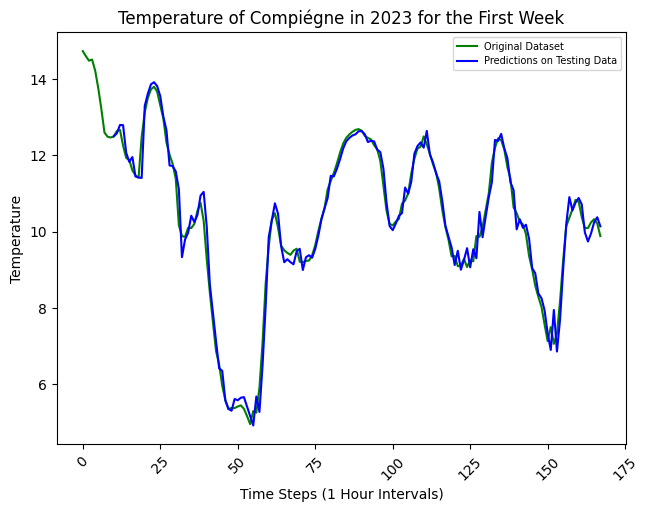

In [35]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(scaler.inverse_transform(df_lstm_testing)[:168], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(testPredictPlot[:168], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023 for the First Week')
plt.show()

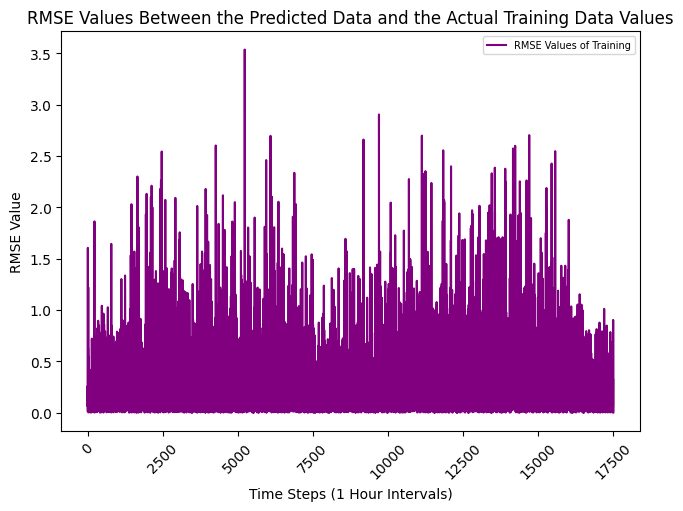

In [41]:
# Creating a graph for the RMSE values

plt.plot(trainRMSE_each, 'purple', label='RMSE Values of Training')
plt.legend(fontsize=7)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('RMSE Value')
plt.title('RMSE Values Between the Predicted Data and the Actual Training Data Values')
plt.show()

In [37]:
# Finding the maximum and minimum RMSE values

maxRMSE_train, minRMSE_train = max(trainRMSE_each), min(trainRMSE_each)

print("Maximum RMSE for training data: ", maxRMSE_train)
print("Minimum RMSE for training data: ", minRMSE_train)

Maximum RMSE for training data:  3.536
Minimum RMSE for training data:  0.0


In [38]:
# Finding the worst guessed and best guessed weeks

window_size = 168  # Length of interval
rolling_avg = np.convolve(trainRMSE_each, np.ones(window_size)/window_size, mode='valid')

# Find the indices of the highest and lowest 168-element average
max_index = np.argmax(rolling_avg)  # Index where the highest average starts
min_index = np.argmin(rolling_avg)  # Index where the lowest average starts

# Extract the corresponding intervals
max_interval = trainRMSE_each[max_index:max_index + window_size]
min_interval = trainRMSE_each[min_index:min_index + window_size]

print(f"Highest 168-element average starts at index {max_index}, value: {np.max(rolling_avg):.3f}")
print(f"Lowest 168-element average starts at index {min_index}, value: {np.min(rolling_avg):.3f}")

Highest 168-element average starts at index 14614, value: 0.444
Lowest 168-element average starts at index 16751, value: 0.150


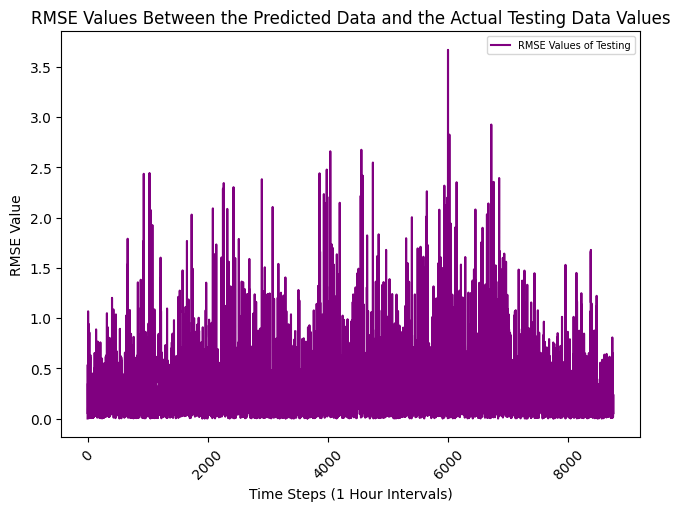

In [42]:
# Creating a graph for the RMSE values

plt.plot(testRMSE_each, 'purple', label='RMSE Values of Testing')
plt.legend(fontsize=7)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('RMSE Value')
plt.title('RMSE Values Between the Predicted Data and the Actual Testing Data Values')
plt.show()

In [43]:
# Finding the maximum and minimum RMSE values

maxRMSE_test, minRMSE_test = max(testRMSE_each), min(testRMSE_each)

print("Maximum RMSE for testing data: ", maxRMSE_test)
print("Minimum RMSE for testing data: ", minRMSE_test)

Maximum RMSE for testing data:  3.668
Minimum RMSE for testing data:  0.0


In [44]:
# Finding the worst guessed and best guessed weeks

window_size = 168  # Length of interval
rolling_avg = np.convolve(testRMSE_each, np.ones(window_size)/window_size, mode='valid')

# Find the indices of the highest and lowest 168-element average
max_index = np.argmax(rolling_avg)  # Index where the highest average starts
min_index = np.argmin(rolling_avg)  # Index where the lowest average starts

# Extract the corresponding intervals
max_interval = testRMSE_each[max_index:max_index + window_size]
min_interval = testRMSE_each[min_index:min_index + window_size]

print(f"Highest 168-element average starts at index {max_index}, value: {np.max(rolling_avg):.3f}")
print(f"Lowest 168-element average starts at index {min_index}, value: {np.min(rolling_avg):.3f}")

Highest 168-element average starts at index 5912, value: 0.529
Lowest 168-element average starts at index 8481, value: 0.146


# Training the ARIMA Model (Temperature Prediction)
The ARIMA model will be trained on data from 2021 and 2022, and tested on data from 2023.

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_7152\2678587325.py:11: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.tight_layout()
d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  fig.canvas.print_figure(bytes_io, **kw)


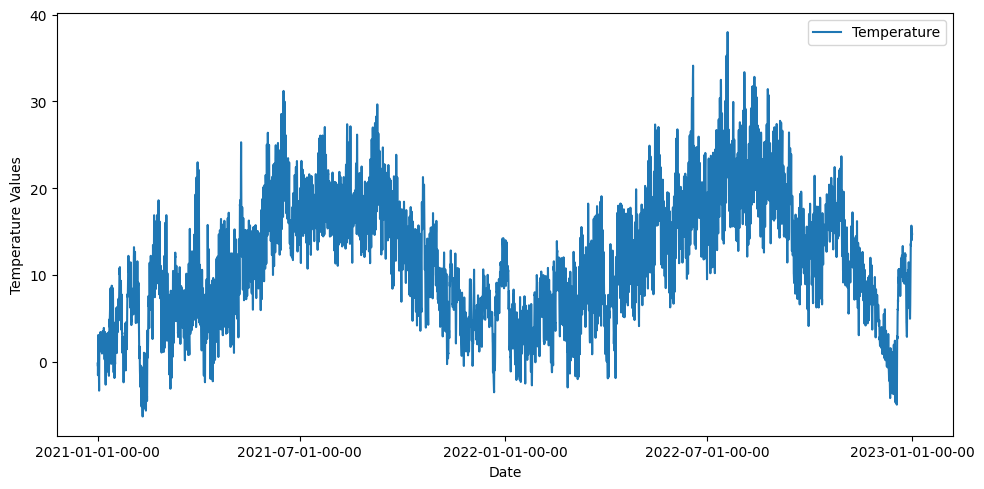

In [50]:
plt.figure(figsize=(10, 5))

plt.plot(df_2021_2022_Temp, label='Temperature')

# Set major x-axis locator to show only 4 dates
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=4))  # Force 4 labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d-%H-%M'))  # Format as 'YYYY-MM-DD-HH-mm'
plt.xlabel("Date")
plt.ylabel("Temperature Values")
plt.legend()
plt.tight_layout()
plt.show()

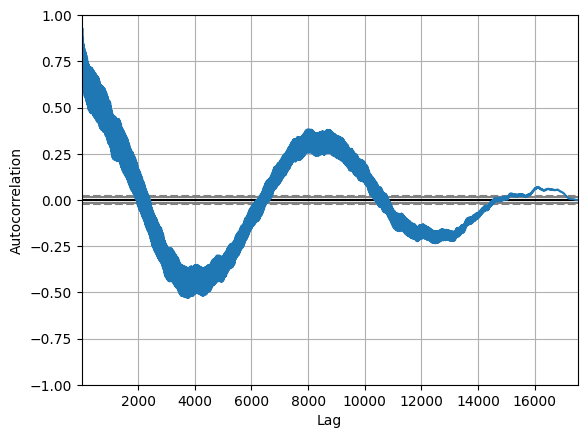

In [51]:
autocorrelation_plot(df_2021_2022_Temp)
plt.show()

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    T2m   No. Observations:                17520
Model:                ARIMA(10, 1, 0)   Log Likelihood              -11891.425
Date:                Thu, 30 Jan 2025   AIC                          23804.850
Time:                        14:03:46   BIC                          23890.331
Sample:                    01-01-2021   HQIC                         23832.997
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8128      0.005    180.368      0.000       0.804       0.822
ar.L2         -0.0754      0.007    -10.275      0.000      -0.090      -0.061
ar.L3         -0.0031      0.009     -0.332      0.7

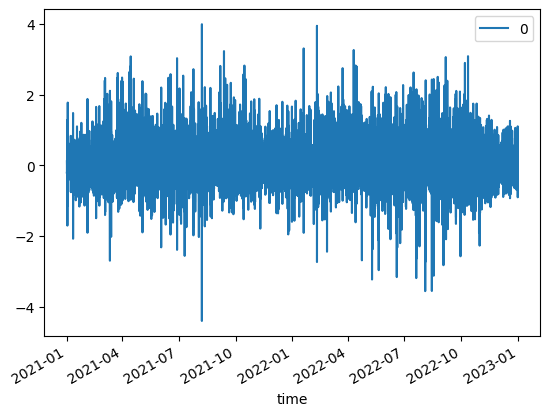

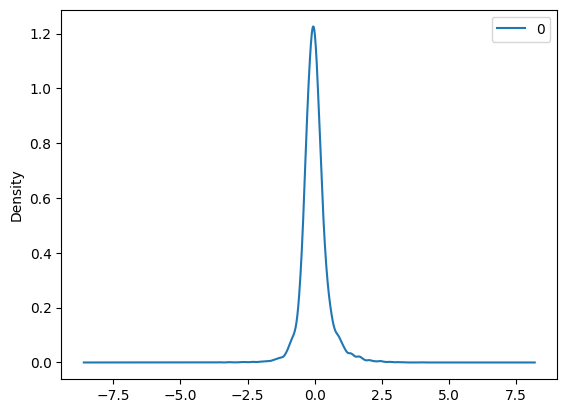

                  0
count  17520.000000
mean       0.000435
std        0.477024
min       -4.401157
25%       -0.249819
50%       -0.035555
75%        0.195513
max        3.996159


In [52]:
# fit model
model_arima = ARIMA(df_2021_2022_Temp, order=(10,1,0))
model_fit = model_arima.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

In [60]:
# split into train and test sets
X = df_2021_2022_Temp.values
Y = df_2023_Temp.values
train_arima, test_arima = X, Y
history = [x for x in train_arima]
predictions = list()
rmse_per_prediction = []  # List to store RMSE per prediction

# Fit the initial ARIMA model only once
model_arima = ARIMA(history, order=(10,1,0))
model_fit = model_arima.fit()

# walk-forward validation
for t in range(len(test_arima)):
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test_arima[t]
	history.append(obs)

    # Instead of retraining, update the model
	model_fit = model_fit.append([obs], refit=False)

	# Compute RMSE for this single prediction
	single_rmse = np.sqrt((yhat - obs) ** 2)
	rmse_per_prediction.append(single_rmse)

	# Calculate completion percentage
	completion_rate = (t + 1) / len(test_arima) * 100
	
	print('predicted=%f, expected=%f, RMSE=%f | %f%% complete' % (yhat, obs, single_rmse, completion_rate))
	
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_arima, predictions))
print('Test RMSE: %.3f' % rmse)

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_7152\4094646012.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('predicted=%f, expected=%f, RMSE=%f | %f%% complete' % (yhat, obs, single_rmse, completion_rate))


predicted=14.601014, expected=14.720000, RMSE=0.118986 | 0.011416% complete
predicted=14.790547, expected=14.590000, RMSE=0.200547 | 0.022831% complete
predicted=14.516508, expected=14.470000, RMSE=0.046508 | 0.034247% complete
predicted=14.435841, expected=14.500000, RMSE=0.064159 | 0.045662% complete
predicted=14.549579, expected=14.210000, RMSE=0.339579 | 0.057078% complete
predicted=13.850380, expected=13.750000, RMSE=0.100380 | 0.068493% complete
predicted=13.417997, expected=13.200000, RMSE=0.217997 | 0.079909% complete
predicted=12.800977, expected=12.590000, RMSE=0.210977 | 0.091324% complete
predicted=12.154809, expected=12.480000, RMSE=0.325191 | 0.102740% complete
predicted=12.479313, expected=12.460000, RMSE=0.019313 | 0.114155% complete
predicted=12.487304, expected=12.490000, RMSE=0.002696 | 0.125571% complete
predicted=12.584482, expected=12.630000, RMSE=0.045518 | 0.136986% complete
predicted=12.798119, expected=12.660000, RMSE=0.138119 | 0.148402% complete
predicted=12

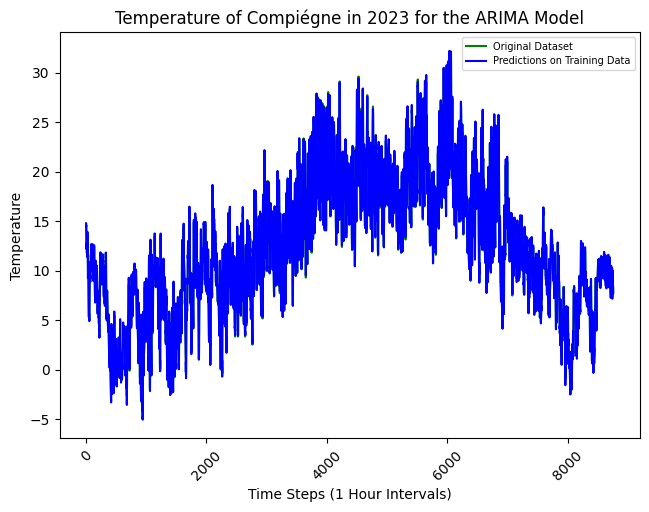

In [61]:
# Plot baseline and predictions

plt.plot(Y, 'g', label='Original Dataset')
plt.plot(predictions, 'b', label='Predictions on Training Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023 for the ARIMA Model')
plt.show()

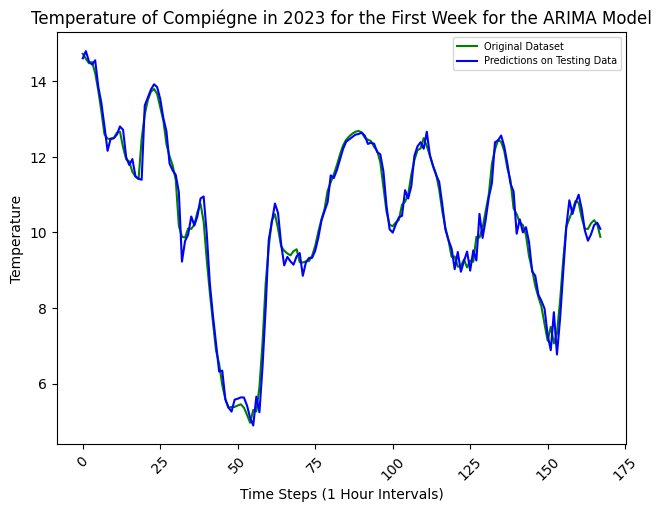

In [62]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(Y[:168], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(predictions[:168], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023 for the First Week for the ARIMA Model')
plt.show()

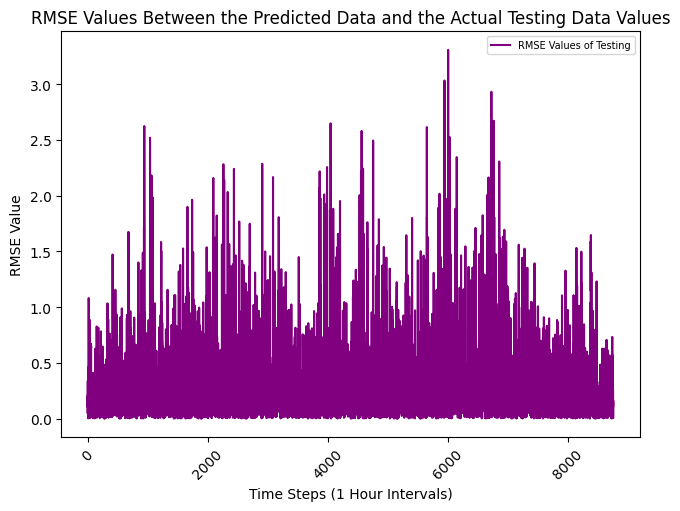

In [63]:
# Creating a graph for the RMSE values

plt.plot(rmse_per_prediction, 'purple', label='RMSE Values of Testing')
plt.legend(fontsize=7)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('RMSE Value')
plt.title('RMSE Values Between the Predicted Data and the Actual Testing Data Values')
plt.show()

In [64]:
# Finding the maximum and minimum RMSE values

maxRMSE_arima, minRMSE_arima = max(rmse_per_prediction), min(rmse_per_prediction)

print("Maximum RMSE for training data: ", maxRMSE_arima)
print("Minimum RMSE for training data: ", minRMSE_arima)

Maximum RMSE for training data:  [3.30857372]
Minimum RMSE for training data:  [5.44641448e-06]


In [67]:
flat_list = [
    x
    for xs in rmse_per_prediction
    for x in xs
]

In [69]:
# Finding the worst guessed and best guessed weeks

window_size = 168  # Length of interval
rolling_avg = np.convolve(flat_list, np.ones(window_size)/window_size, mode='valid')

# Find the indices of the highest and lowest 168-element average
max_index = np.argmax(rolling_avg)  # Index where the highest average starts
min_index = np.argmin(rolling_avg)  # Index where the lowest average starts

# Extract the corresponding intervals
max_interval = flat_list[max_index:max_index + window_size]
min_interval = flat_list[min_index:min_index + window_size]

print(f"Highest 168-element average starts at index {max_index}, value: {np.max(rolling_avg):.3f}")
print(f"Lowest 168-element average starts at index {min_index}, value: {np.min(rolling_avg):.3f}")

Highest 168-element average starts at index 6700, value: 0.421
Lowest 168-element average starts at index 8487, value: 0.141


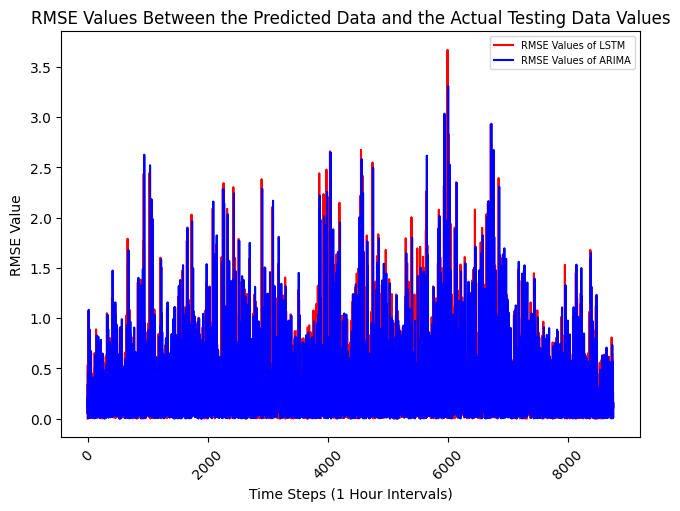

In [70]:
# Creating a graph for the RMSE values for both models

# For LSTM

plt.plot(testRMSE_each, 'r', label='RMSE Values of LSTM')
plt.legend(fontsize=7)

# For ARIMA

plt.plot(flat_list, 'b', label='RMSE Values of ARIMA')
plt.legend(fontsize=7)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('RMSE Value')
plt.title('RMSE Values Between the Predicted Data and the Actual Testing Data Values')
plt.show()

# LSTM Model for Look Back = 24

In [71]:
df_2021_2022

P  G(i)  H_sun    T2m  WS10m  Int
time                                                    
2021-01-01 00:10:00  0.0   0.0    0.0  -0.21   1.59  0.0
2021-01-01 01:10:00  0.0   0.0    0.0  -0.44   1.59  0.0
2021-01-01 02:10:00  0.0   0.0    0.0  -0.48   1.38  0.0
2021-01-01 03:10:00  0.0   0.0    0.0  -0.47   1.24  0.0
2021-01-01 04:10:00  0.0   0.0    0.0  -0.50   1.24  0.0
...                  ...   ...    ...    ...    ...  ...
2022-12-31 19:10:00  0.0   0.0    0.0  14.96   7.66  0.0
2022-12-31 20:10:00  0.0   0.0    0.0  14.90   7.52  0.0
2022-12-31 21:10:00  0.0   0.0    0.0  14.84   7.45  0.0
2022-12-31 22:10:00  0.0   0.0    0.0  14.84   7.66  0.0
2022-12-31 23:10:00  0.0   0.0    0.0  14.71   7.86  0.0

[17520 rows x 6 columns]

In [72]:
df_2021_2022_Temp = df_2021_2022.iloc[:, [3]]

print(df_2021_2022_Temp.head())

df_2023_Temp = df_2023.iloc[:, [3]]

print(df_2023_Temp.head())

                      T2m
time                     
2021-01-01 00:10:00 -0.21
2021-01-01 01:10:00 -0.44
2021-01-01 02:10:00 -0.48
2021-01-01 03:10:00 -0.47
2021-01-01 04:10:00 -0.50
                       T2m
time                      
2023-01-01 00:10:00  14.72
2023-01-01 01:10:00  14.59
2023-01-01 02:10:00  14.47
2023-01-01 03:10:00  14.50
2023-01-01 04:10:00  14.21


In [73]:
# Preparing dataset for LSTM training

df_lstm_training = df_2021_2022_Temp.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = df_2023_Temp.values
df_lstm_testing = df_lstm_testing.astype('float32')

In [74]:
# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

In [75]:
# Convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [76]:
# Reshape into X=t and Y=t+1

look_back = 24 # Predicting the next value based on how many previous values
trainX, trainY = create_dataset(df_lstm_training, look_back)
testX, testY = create_dataset(df_lstm_testing, look_back)

In [77]:
# Reshape input to be [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [78]:
np.shape(trainX)

(17495, 1, 24)

In [79]:
# Create and fit the LSTM network

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=300, batch_size=6, verbose=2)

Epoch 1/300


d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2916/2916 - 9s - 3ms/step - loss: 0.0050
Epoch 2/300
2916/2916 - 7s - 2ms/step - loss: 6.1159e-04
Epoch 3/300
2916/2916 - 7s - 2ms/step - loss: 3.0897e-04
Epoch 4/300
2916/2916 - 7s - 2ms/step - loss: 2.4612e-04
Epoch 5/300
2916/2916 - 7s - 2ms/step - loss: 2.1942e-04
Epoch 6/300
2916/2916 - 7s - 2ms/step - loss: 2.0279e-04
Epoch 7/300
2916/2916 - 7s - 2ms/step - loss: 1.9090e-04
Epoch 8/300
2916/2916 - 7s - 2ms/step - loss: 1.8175e-04
Epoch 9/300
2916/2916 - 7s - 2ms/step - loss: 1.7440e-04
Epoch 10/300
2916/2916 - 7s - 3ms/step - loss: 1.6830e-04
Epoch 11/300
2916/2916 - 7s - 3ms/step - loss: 1.6313e-04
Epoch 12/300
2916/2916 - 7s - 2ms/step - loss: 1.5869e-04
Epoch 13/300
2916/2916 - 7s - 3ms/step - loss: 1.5484e-04
Epoch 14/300
2916/2916 - 8s - 3ms/step - loss: 1.5147e-04
Epoch 15/300
2916/2916 - 7s - 2ms/step - loss: 1.4850e-04
Epoch 16/300
2916/2916 - 8s - 3ms/step - loss: 1.4587e-04
Epoch 17/300
2916/2916 - 7s - 3ms/step - loss: 1.4352e-04
Epoch 18/300
2916/2916 - 7s - 3ms/step 

In [80]:
# Make predictions

trainPredict_LSTM = model.predict(trainX)
testPredict_LSTM = model.predict(testX)

# Invert predictions

trainPredict_LSTM = scaler.inverse_transform(trainPredict_LSTM)
trainY = scaler.inverse_transform([trainY])
testPredict_LSTM = scaler.inverse_transform(testPredict_LSTM)
testY = scaler.inverse_transform([testY])

# Calculate overall root mean squared error

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict_LSTM[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict_LSTM[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train Score: 0.36 RMSE
Test Score: 0.40 RMSE


In [81]:
# Compute per-prediction RMSE (not aggregated)
trainRMSE_each = np.sqrt((trainPredict_LSTM[:,0] - trainY[0]) ** 2)
testRMSE_each = np.sqrt((testPredict_LSTM[:,0] - testY[0]) ** 2)

# Round RMSE values to 3 decimal places
trainRMSE_each = np.round(trainRMSE_each, 3)
testRMSE_each = np.round(testRMSE_each, 3)

# Print first 10 RMSE values as an example
print("First 10 Train RMSE values:", trainRMSE_each[:10])
print("First 10 Test RMSE values:", testRMSE_each[:10])

First 10 Train RMSE values: [0.206 0.246 0.477 0.178 0.03  0.022 0.101 1.115 0.032 0.846]
First 10 Test RMSE values: [0.217 0.337 0.219 0.396 0.05  0.005 0.199 1.017 0.245 0.014]


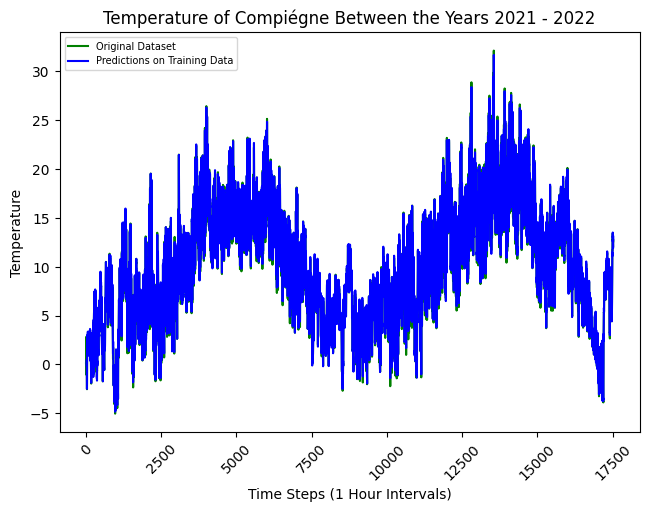

In [82]:
# Shift train predictions for plotting

trainPredictPlot = np.empty_like(df_lstm_training)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict_LSTM)+look_back, :] = trainPredict_LSTM

# Plot baseline and predictions

plt.plot(scaler.inverse_transform(df_lstm_training), 'g', label='Original Dataset')
plt.plot(trainPredictPlot, 'b', label='Predictions on Training Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne Between the Years 2021 - 2022')
plt.show()

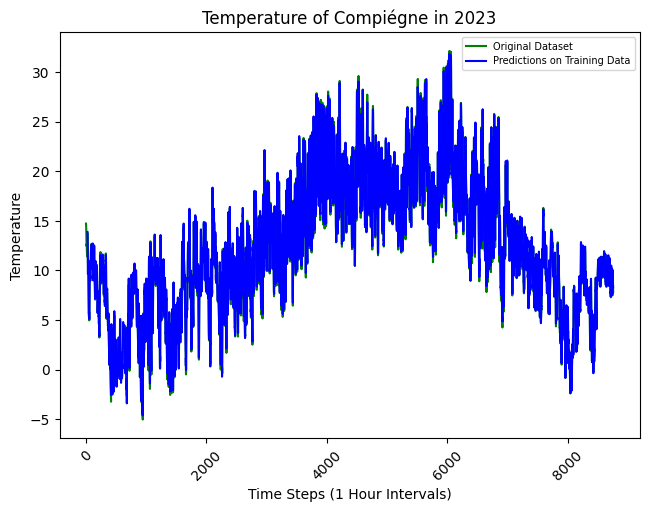

In [83]:
# Shift train predictions for plotting

testPredictPlot = np.empty_like(df_lstm_testing)
testPredictPlot[:, :] = np.nan
testPredictPlot[look_back:len(testPredict_LSTM)+look_back, :] = testPredict_LSTM

# Plot baseline and predictions

plt.plot(scaler.inverse_transform(df_lstm_testing), 'g', label='Original Dataset')
plt.plot(testPredictPlot, 'b', label='Predictions on Training Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023')
plt.show()

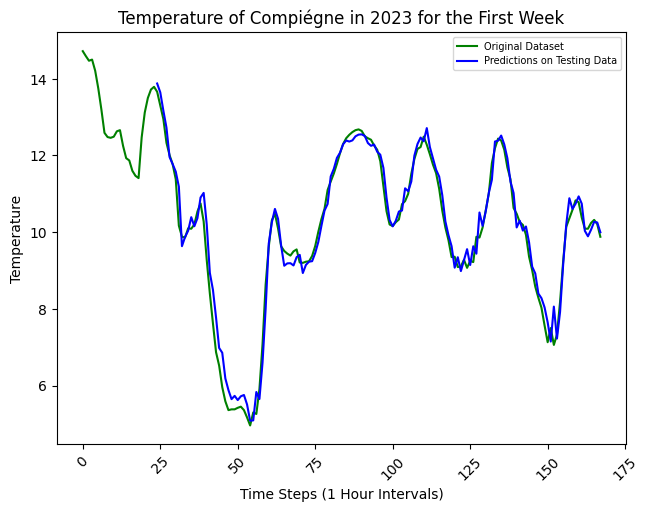

In [84]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(scaler.inverse_transform(df_lstm_testing)[:168], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(testPredictPlot[:168], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023 for the First Week')
plt.show()

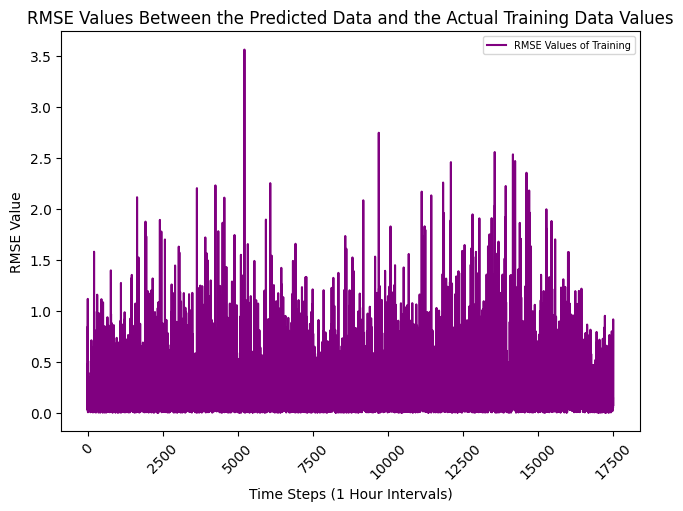

In [85]:
# Creating a graph for the RMSE values

plt.plot(trainRMSE_each, 'purple', label='RMSE Values of Training')
plt.legend(fontsize=7)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('RMSE Value')
plt.title('RMSE Values Between the Predicted Data and the Actual Training Data Values')
plt.show()

In [86]:
# Finding the maximum and minimum RMSE values

maxRMSE_train, minRMSE_train = max(trainRMSE_each), min(trainRMSE_each)

print("Maximum RMSE for training data: ", maxRMSE_train)
print("Minimum RMSE for training data: ", minRMSE_train)

Maximum RMSE for training data:  3.558
Minimum RMSE for training data:  0.0


In [87]:
# Finding the worst guessed and best guessed weeks

window_size = 168  # Length of interval
rolling_avg = np.convolve(trainRMSE_each, np.ones(window_size)/window_size, mode='valid')

# Find the indices of the highest and lowest 168-element average
max_index = np.argmax(rolling_avg)  # Index where the highest average starts
min_index = np.argmin(rolling_avg)  # Index where the lowest average starts

# Extract the corresponding intervals
max_interval = trainRMSE_each[max_index:max_index + window_size]
min_interval = trainRMSE_each[min_index:min_index + window_size]

print(f"Highest 168-element average starts at index {max_index}, value: {np.max(rolling_avg):.3f}")
print(f"Lowest 168-element average starts at index {min_index}, value: {np.min(rolling_avg):.3f}")

Highest 168-element average starts at index 14603, value: 0.393
Lowest 168-element average starts at index 16721, value: 0.133


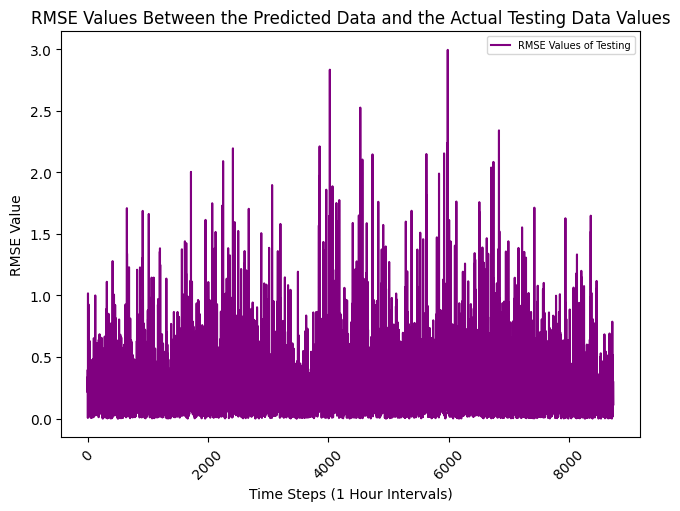

In [88]:
# Creating a graph for the RMSE values

plt.plot(testRMSE_each, 'purple', label='RMSE Values of Testing')
plt.legend(fontsize=7)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('RMSE Value')
plt.title('RMSE Values Between the Predicted Data and the Actual Testing Data Values')
plt.show()

In [89]:
# Finding the maximum and minimum RMSE values

maxRMSE_test, minRMSE_test = max(testRMSE_each), min(testRMSE_each)

print("Maximum RMSE for testing data: ", maxRMSE_test)
print("Minimum RMSE for testing data: ", minRMSE_test)

Maximum RMSE for testing data:  2.995
Minimum RMSE for testing data:  0.0


In [90]:
# Finding the worst guessed and best guessed weeks

window_size = 168  # Length of interval
rolling_avg = np.convolve(testRMSE_each, np.ones(window_size)/window_size, mode='valid')

# Find the indices of the highest and lowest 168-element average
max_index = np.argmax(rolling_avg)  # Index where the highest average starts
min_index = np.argmin(rolling_avg)  # Index where the lowest average starts

# Extract the corresponding intervals
max_interval = testRMSE_each[max_index:max_index + window_size]
min_interval = testRMSE_each[min_index:min_index + window_size]

print(f"Highest 168-element average starts at index {max_index}, value: {np.max(rolling_avg):.3f}")
print(f"Lowest 168-element average starts at index {min_index}, value: {np.min(rolling_avg):.3f}")

Highest 168-element average starts at index 5884, value: 0.447
Lowest 168-element average starts at index 8466, value: 0.151


# ARIMA Model for q = 24

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_16532\2678587325.py:11: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.tight_layout()
d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  fig.canvas.print_figure(bytes_io, **kw)


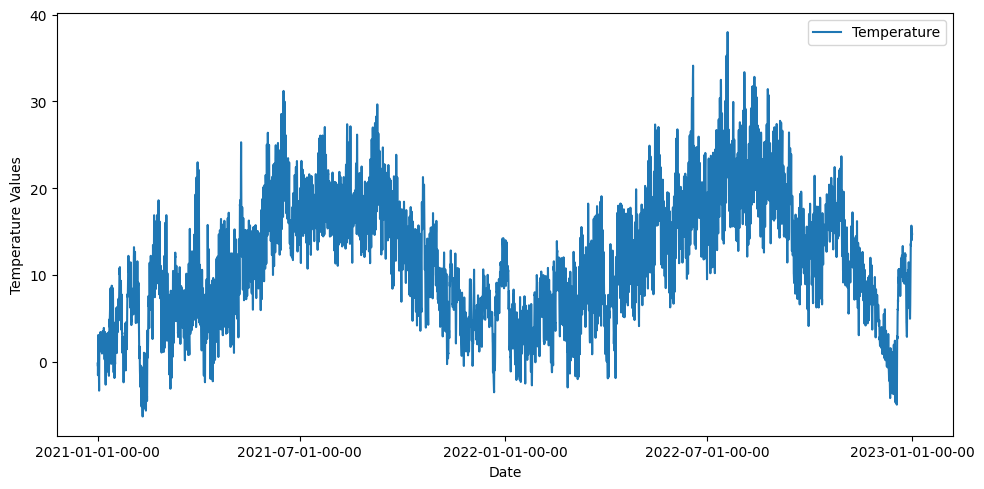

In [11]:
plt.figure(figsize=(10, 5))

plt.plot(df_2021_2022_Temp, label='Temperature')

# Set major x-axis locator to show only 4 dates
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=4))  # Force 4 labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d-%H-%M'))  # Format as 'YYYY-MM-DD-HH-mm'
plt.xlabel("Date")
plt.ylabel("Temperature Values")
plt.legend()
plt.tight_layout()
plt.show()

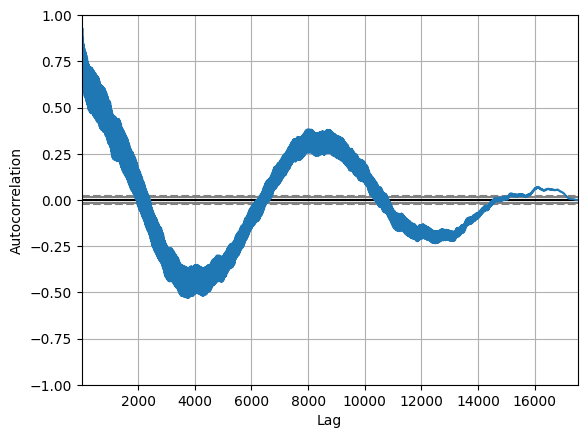

In [12]:
autocorrelation_plot(df_2021_2022_Temp)
plt.show()

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    T2m   No. Observations:                17520
Model:                ARIMA(10, 1, 0)   Log Likelihood              -11891.425
Date:                Fri, 31 Jan 2025   AIC                          23804.850
Time:                        09:35:44   BIC                          23890.331
Sample:                    01-01-2021   HQIC                         23832.997
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8128      0.005    180.368      0.000       0.804       0.822
ar.L2         -0.0754      0.007    -10.275      0.000      -0.090      -0.061
ar.L3         -0.0031      0.009     -0.332      0.7

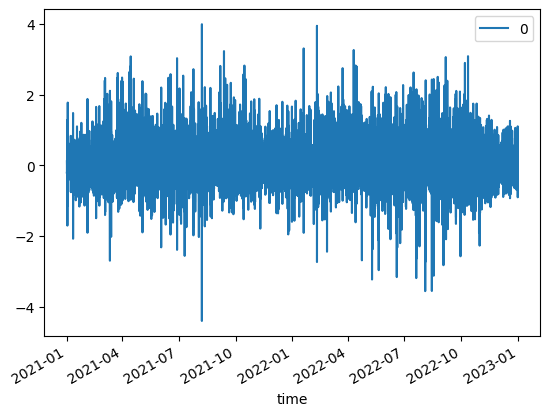

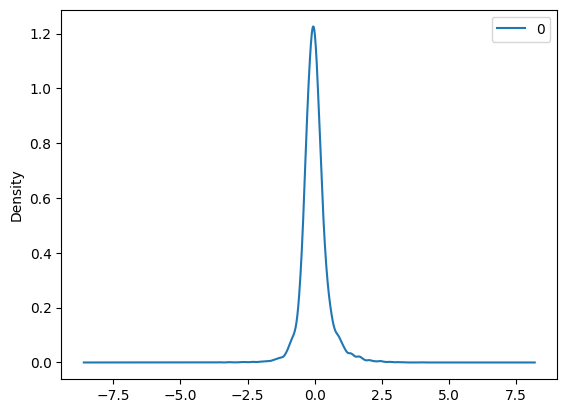

                  0
count  17520.000000
mean       0.000435
std        0.477024
min       -4.401157
25%       -0.249819
50%       -0.035555
75%        0.195513
max        3.996159


In [13]:
# fit model
model_arima = ARIMA(df_2021_2022_Temp, order=(10,1,0))
model_fit = model_arima.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

In [14]:
# split into train and test sets
X = df_2021_2022_Temp.values
Y = df_2023_Temp.values
train_arima, test_arima = X, Y
history = [x for x in train_arima]
predictions = list()
rmse_per_prediction = []  # List to store RMSE per prediction

# Fit the initial ARIMA model only once
model_arima = ARIMA(history, order=(24,1,0))
model_fit = model_arima.fit()

# walk-forward validation
for t in range(len(test_arima)):
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test_arima[t]
	history.append(obs)

    # Instead of retraining, update the model
	model_fit = model_fit.append([obs], refit=False)

	# Compute RMSE for this single prediction
	single_rmse = np.sqrt((yhat - obs) ** 2)
	rmse_per_prediction.append(single_rmse)

	# Calculate completion percentage
	completion_rate = (t + 1) / len(test_arima) * 100
	
	print('predicted=%f, expected=%f, RMSE=%f | %f%% complete' % (yhat, obs, single_rmse, completion_rate))
	
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_arima, predictions))
print('Test RMSE: %.3f' % rmse)

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_16532\482751388.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('predicted=%f, expected=%f, RMSE=%f | %f%% complete' % (yhat, obs, single_rmse, completion_rate))


predicted=14.689199, expected=14.720000, RMSE=0.030801 | 0.011416% complete
predicted=14.818073, expected=14.590000, RMSE=0.228073 | 0.022831% complete
predicted=14.570987, expected=14.470000, RMSE=0.100987 | 0.034247% complete
predicted=14.530704, expected=14.500000, RMSE=0.030704 | 0.045662% complete
predicted=14.574032, expected=14.210000, RMSE=0.364032 | 0.057078% complete
predicted=14.068970, expected=13.750000, RMSE=0.318970 | 0.068493% complete
predicted=13.596976, expected=13.200000, RMSE=0.396976 | 0.079909% complete
predicted=13.030446, expected=12.590000, RMSE=0.440446 | 0.091324% complete
predicted=12.351464, expected=12.480000, RMSE=0.128536 | 0.102740% complete
predicted=12.472805, expected=12.460000, RMSE=0.012805 | 0.114155% complete
predicted=12.498039, expected=12.490000, RMSE=0.008039 | 0.125571% complete
predicted=12.602412, expected=12.630000, RMSE=0.027588 | 0.136986% complete
predicted=12.758065, expected=12.660000, RMSE=0.098065 | 0.148402% complete
predicted=12

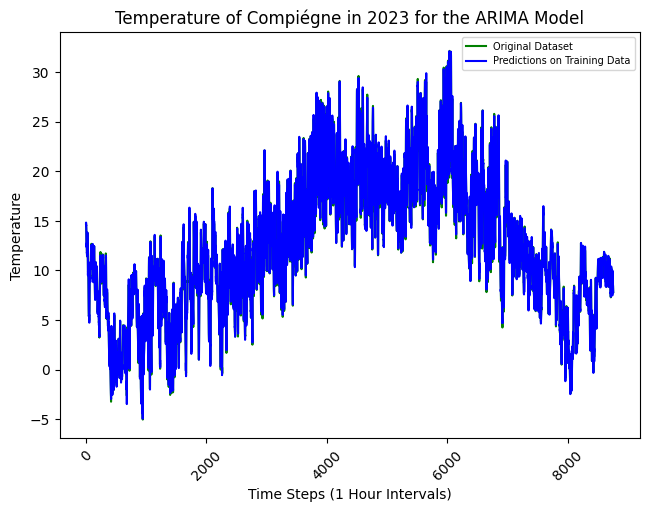

In [15]:
# Plot baseline and predictions

plt.plot(Y, 'g', label='Original Dataset')
plt.plot(predictions, 'b', label='Predictions on Training Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023 for the ARIMA Model')
plt.show()

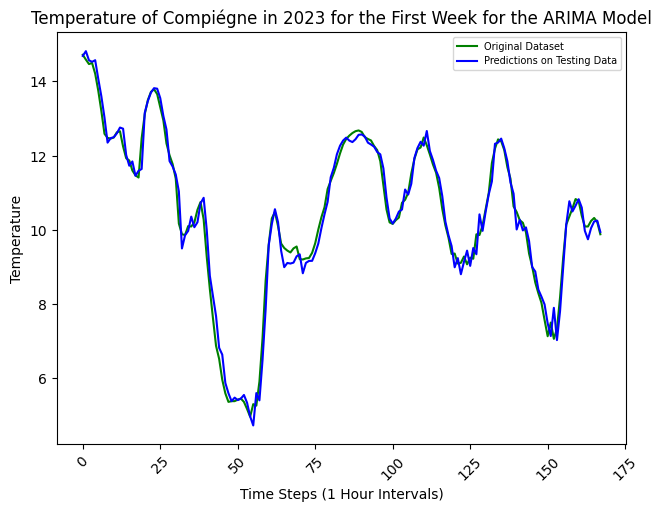

In [16]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(Y[:168], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(predictions[:168], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023 for the First Week for the ARIMA Model')
plt.show()

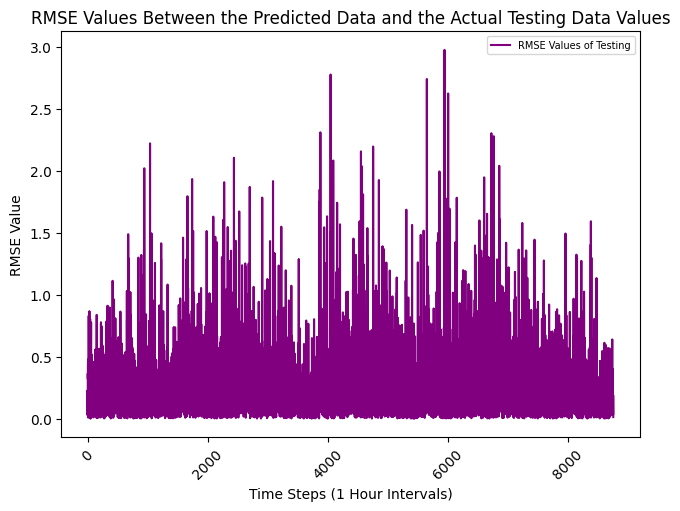

In [17]:
# Creating a graph for the RMSE values

plt.plot(rmse_per_prediction, 'purple', label='RMSE Values of Testing')
plt.legend(fontsize=7)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('RMSE Value')
plt.title('RMSE Values Between the Predicted Data and the Actual Testing Data Values')
plt.show()

In [18]:
# Finding the maximum and minimum RMSE values

maxRMSE_arima, minRMSE_arima = max(rmse_per_prediction), min(rmse_per_prediction)

print("Maximum RMSE for training data: ", maxRMSE_arima)
print("Minimum RMSE for training data: ", minRMSE_arima)

Maximum RMSE for training data:  [2.97364023]
Minimum RMSE for training data:  [2.20261743e-06]


In [19]:
flat_list = [
    x
    for xs in rmse_per_prediction
    for x in xs
]

In [20]:
# Finding the worst guessed and best guessed weeks

window_size = 168  # Length of interval
rolling_avg = np.convolve(flat_list, np.ones(window_size)/window_size, mode='valid')

# Find the indices of the highest and lowest 168-element average
max_index = np.argmax(rolling_avg)  # Index where the highest average starts
min_index = np.argmin(rolling_avg)  # Index where the lowest average starts

# Extract the corresponding intervals
max_interval = flat_list[max_index:max_index + window_size]
min_interval = flat_list[min_index:min_index + window_size]

print(f"Highest 168-element average starts at index {max_index}, value: {np.max(rolling_avg):.3f}")
print(f"Lowest 168-element average starts at index {min_index}, value: {np.min(rolling_avg):.3f}")

Highest 168-element average starts at index 4016, value: 0.373
Lowest 168-element average starts at index 3569, value: 0.142


In [21]:
# Load the array
testRMSE_each = np.load("testRMSE_each.npy")
testPredict_LSTM = np.load("testPredict_LSTM.npy")

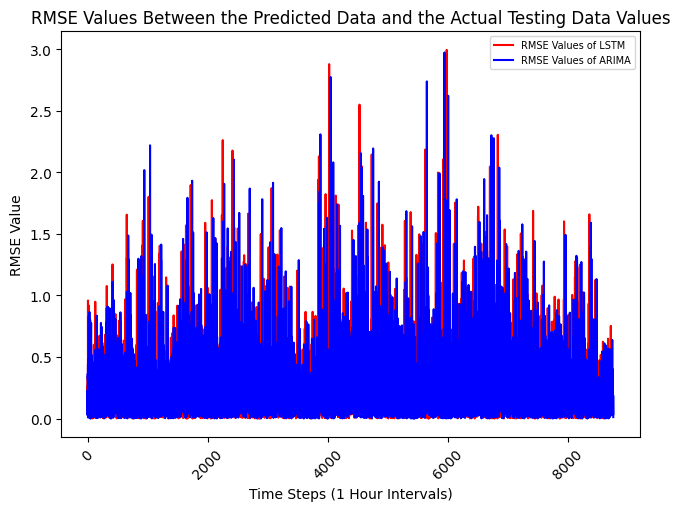

In [22]:
# Creating a graph for the RMSE values for both models

# For LSTM

plt.plot(testRMSE_each, 'r', label='RMSE Values of LSTM')
plt.legend(fontsize=7)

# For ARIMA

plt.plot(flat_list, 'b', label='RMSE Values of ARIMA')
plt.legend(fontsize=7)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('RMSE Value')
plt.title('RMSE Values Between the Predicted Data and the Actual Testing Data Values')
plt.show()

# Training the LSTM Model (Global Horizontal Irradiance Prediction)
The LSTM model will be trained on data from 2021 and 2022, and tested on data from 2023.

In [10]:
df_2021_2022

P  G(i)  H_sun    T2m  WS10m  Int
time                                                    
2021-01-01 00:10:00  0.0   0.0    0.0  -0.21   1.59  0.0
2021-01-01 01:10:00  0.0   0.0    0.0  -0.44   1.59  0.0
2021-01-01 02:10:00  0.0   0.0    0.0  -0.48   1.38  0.0
2021-01-01 03:10:00  0.0   0.0    0.0  -0.47   1.24  0.0
2021-01-01 04:10:00  0.0   0.0    0.0  -0.50   1.24  0.0
...                  ...   ...    ...    ...    ...  ...
2022-12-31 19:10:00  0.0   0.0    0.0  14.96   7.66  0.0
2022-12-31 20:10:00  0.0   0.0    0.0  14.90   7.52  0.0
2022-12-31 21:10:00  0.0   0.0    0.0  14.84   7.45  0.0
2022-12-31 22:10:00  0.0   0.0    0.0  14.84   7.66  0.0
2022-12-31 23:10:00  0.0   0.0    0.0  14.71   7.86  0.0

[17520 rows x 6 columns]

In [11]:
df_2021_2022_Irr = df_2021_2022.iloc[:, [1]]

print(df_2021_2022_Irr.head())

df_2023_Irr = df_2023.iloc[:, [1]]

print(df_2023_Irr.head())

                     G(i)
time                     
2021-01-01 00:10:00   0.0
2021-01-01 01:10:00   0.0
2021-01-01 02:10:00   0.0
2021-01-01 03:10:00   0.0
2021-01-01 04:10:00   0.0
                     G(i)
time                     
2023-01-01 00:10:00   0.0
2023-01-01 01:10:00   0.0
2023-01-01 02:10:00   0.0
2023-01-01 03:10:00   0.0
2023-01-01 04:10:00   0.0


In [12]:
# Preparing dataset for LSTM training

df_lstm_training = df_2021_2022_Irr.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = df_2023_Irr.values
df_lstm_testing = df_lstm_testing.astype('float32')

In [13]:
# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

In [14]:
# Convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [15]:
# Reshape into X=t and Y=t+1

look_back = 24 # Predicting the next value based on how many previous values
trainX, trainY = create_dataset(df_lstm_training, look_back)
testX, testY = create_dataset(df_lstm_testing, look_back)

In [16]:
# Reshape input to be [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [17]:
np.shape(trainX)

(17495, 1, 24)

In [18]:
# Create and fit the LSTM network

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=300, batch_size=6, verbose=2)

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
2916/2916 - 12s - 4ms/step - loss: 0.0103
Epoch 2/300
2916/2916 - 7s - 3ms/step - loss: 0.0073
Epoch 3/300
2916/2916 - 7s - 3ms/step - loss: 0.0071
Epoch 4/300
2916/2916 - 7s - 3ms/step - loss: 0.0070
Epoch 5/300
2916/2916 - 8s - 3ms/step - loss: 0.0069
Epoch 6/300
2916/2916 - 7s - 3ms/step - loss: 0.0069
Epoch 7/300
2916/2916 - 7s - 2ms/step - loss: 0.0069
Epoch 8/300
2916/2916 - 8s - 3ms/step - loss: 0.0068
Epoch 9/300
2916/2916 - 8s - 3ms/step - loss: 0.0068
Epoch 10/300
2916/2916 - 8s - 3ms/step - loss: 0.0068
Epoch 11/300
2916/2916 - 8s - 3ms/step - loss: 0.0068
Epoch 12/300
2916/2916 - 8s - 3ms/step - loss: 0.0068
Epoch 13/300
2916/2916 - 8s - 3ms/step - loss: 0.0067
Epoch 14/300
2916/2916 - 8s - 3ms/step - loss: 0.0067
Epoch 15/300
2916/2916 - 8s - 3ms/step - loss: 0.0067
Epoch 16/300
2916/2916 - 8s - 3ms/step - loss: 0.0067
Epoch 17/300
2916/2916 - 7s - 2ms/step - loss: 0.0067
Epoch 18/300
2916/2916 - 8s - 3ms/step - loss: 0.0067
Epoch 19/300
2916/2916 - 8s - 3ms/st

In [19]:
# Make predictions

trainPredict_LSTM = model.predict(trainX)
testPredict_LSTM = model.predict(testX)

# Invert predictions

trainPredict_LSTM = scaler.inverse_transform(trainPredict_LSTM)
trainY = scaler.inverse_transform([trainY])
testPredict_LSTM = scaler.inverse_transform(testPredict_LSTM)
testY = scaler.inverse_transform([testY])

# Calculate overall root mean squared error

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict_LSTM[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict_LSTM[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train Score: 84.71 RMSE
Test Score: 90.74 RMSE


In [20]:
# Compute per-prediction RMSE (not aggregated)
trainRMSE_each = np.sqrt((trainPredict_LSTM[:,0] - trainY[0]) ** 2)
testRMSE_each = np.sqrt((testPredict_LSTM[:,0] - testY[0]) ** 2)

# Round RMSE values to 3 decimal places
trainRMSE_each = np.round(trainRMSE_each, 3)
testRMSE_each = np.round(testRMSE_each, 3)

# Print first 10 RMSE values as an example
print("First 10 Train RMSE values:", trainRMSE_each[:10])
print("First 10 Test RMSE values:", testRMSE_each[:10])

First 10 Train RMSE values: [  0.385   1.673   3.436  18.661   0.998   3.833  15.48   36.357  46.05
 117.085]
First 10 Test RMSE values: [ 1.79   3.169  2.952  7.422  9.189  0.712 10.803  9.657 36.83  30.425]


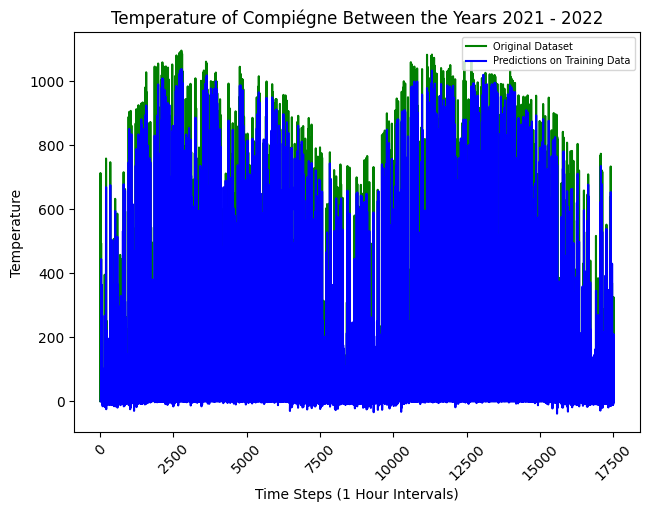

In [21]:
# Shift train predictions for plotting

trainPredictPlot = np.empty_like(df_lstm_training)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict_LSTM)+look_back, :] = trainPredict_LSTM

# Plot baseline and predictions

plt.plot(scaler.inverse_transform(df_lstm_training), 'g', label='Original Dataset')
plt.plot(trainPredictPlot, 'b', label='Predictions on Training Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne Between the Years 2021 - 2022')
plt.show()

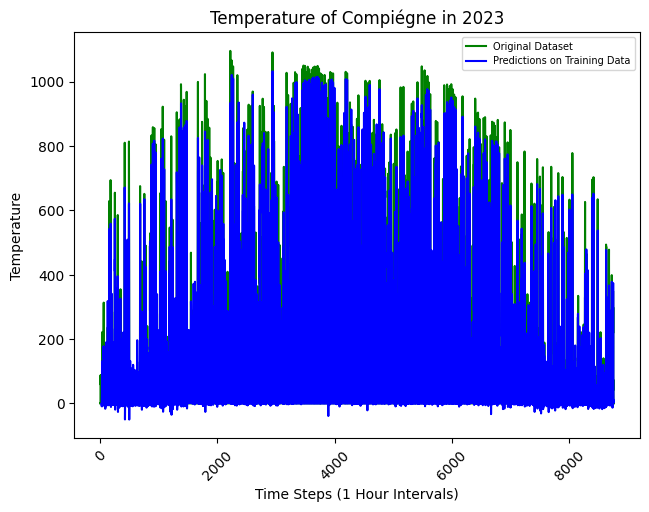

In [22]:
# Shift train predictions for plotting

testPredictPlot = np.empty_like(df_lstm_testing)
testPredictPlot[:, :] = np.nan
testPredictPlot[look_back:len(testPredict_LSTM)+look_back, :] = testPredict_LSTM

# Plot baseline and predictions

plt.plot(scaler.inverse_transform(df_lstm_testing), 'g', label='Original Dataset')
plt.plot(testPredictPlot, 'b', label='Predictions on Training Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023')
plt.show()

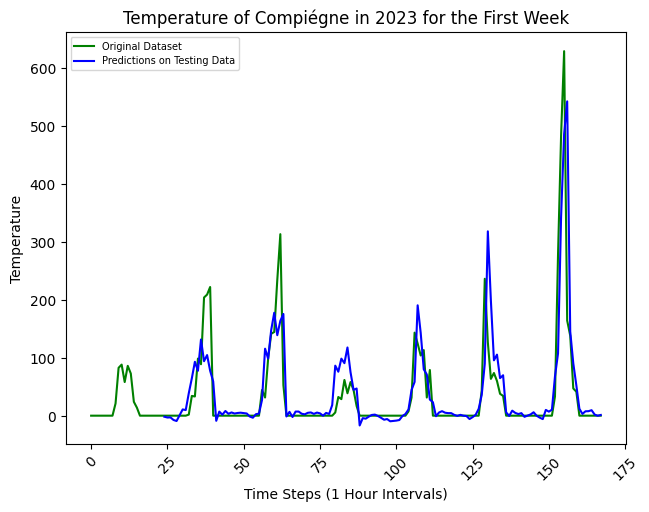

In [23]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(scaler.inverse_transform(df_lstm_testing)[:168], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(testPredictPlot[:168], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023 for the First Week')
plt.show()

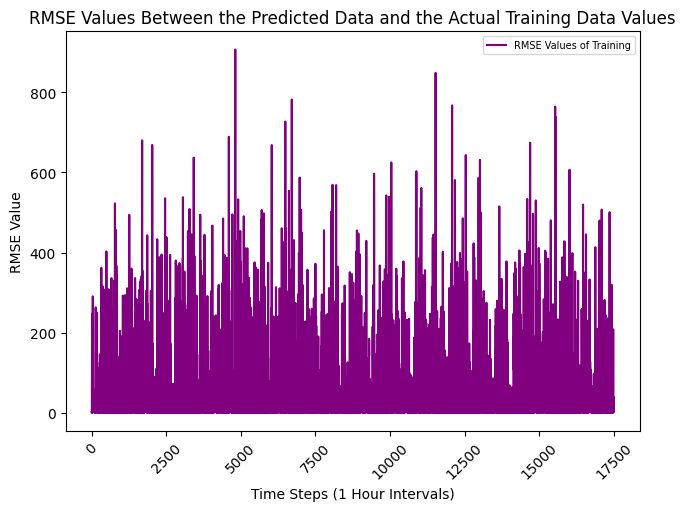

In [24]:
# Creating a graph for the RMSE values

plt.plot(trainRMSE_each, 'purple', label='RMSE Values of Training')
plt.legend(fontsize=7)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('RMSE Value')
plt.title('RMSE Values Between the Predicted Data and the Actual Training Data Values')
plt.show()

In [25]:
# Finding the maximum and minimum RMSE values

maxRMSE_train, minRMSE_train = max(trainRMSE_each), min(trainRMSE_each)

print("Maximum RMSE for training data: ", maxRMSE_train)
print("Minimum RMSE for training data: ", minRMSE_train)

Maximum RMSE for training data:  907.002
Minimum RMSE for training data:  0.0


In [26]:
# Finding the worst guessed and best guessed weeks

window_size = 168  # Length of interval
rolling_avg = np.convolve(trainRMSE_each, np.ones(window_size)/window_size, mode='valid')

# Find the indices of the highest and lowest 168-element average
max_index = np.argmax(rolling_avg)  # Index where the highest average starts
min_index = np.argmin(rolling_avg)  # Index where the lowest average starts

# Extract the corresponding intervals
max_interval = trainRMSE_each[max_index:max_index + window_size]
min_interval = trainRMSE_each[min_index:min_index + window_size]

print(f"Highest 168-element average starts at index {max_index}, value: {np.max(rolling_avg):.3f}")
print(f"Lowest 168-element average starts at index {min_index}, value: {np.min(rolling_avg):.3f}")

Highest 168-element average starts at index 3187, value: 69.074
Lowest 168-element average starts at index 16717, value: 12.110


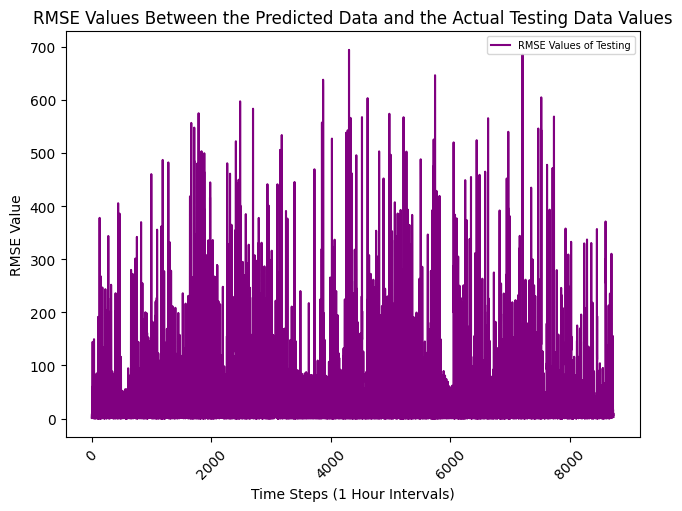

In [27]:
# Creating a graph for the RMSE values

plt.plot(testRMSE_each, 'purple', label='RMSE Values of Testing')
plt.legend(fontsize=7)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('RMSE Value')
plt.title('RMSE Values Between the Predicted Data and the Actual Testing Data Values')
plt.show()

In [28]:
# Finding the maximum and minimum RMSE values

maxRMSE_test, minRMSE_test = max(testRMSE_each), min(testRMSE_each)

print("Maximum RMSE for testing data: ", maxRMSE_test)
print("Minimum RMSE for testing data: ", minRMSE_test)

Maximum RMSE for testing data:  694.362
Minimum RMSE for testing data:  0.001


In [29]:
# Finding the worst guessed and best guessed weeks

window_size = 168  # Length of interval
rolling_avg = np.convolve(testRMSE_each, np.ones(window_size)/window_size, mode='valid')

# Find the indices of the highest and lowest 168-element average
max_index = np.argmax(rolling_avg)  # Index where the highest average starts
min_index = np.argmin(rolling_avg)  # Index where the lowest average starts

# Extract the corresponding intervals
max_interval = testRMSE_each[max_index:max_index + window_size]
min_interval = testRMSE_each[min_index:min_index + window_size]

print(f"Highest 168-element average starts at index {max_index}, value: {np.max(rolling_avg):.3f}")
print(f"Lowest 168-element average starts at index {min_index}, value: {np.min(rolling_avg):.3f}")

Highest 168-element average starts at index 4283, value: 76.983
Lowest 168-element average starts at index 489, value: 14.307


# ARIMA Model for q = 24

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_14840\3829366574.py:11: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.tight_layout()
d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  fig.canvas.print_figure(bytes_io, **kw)


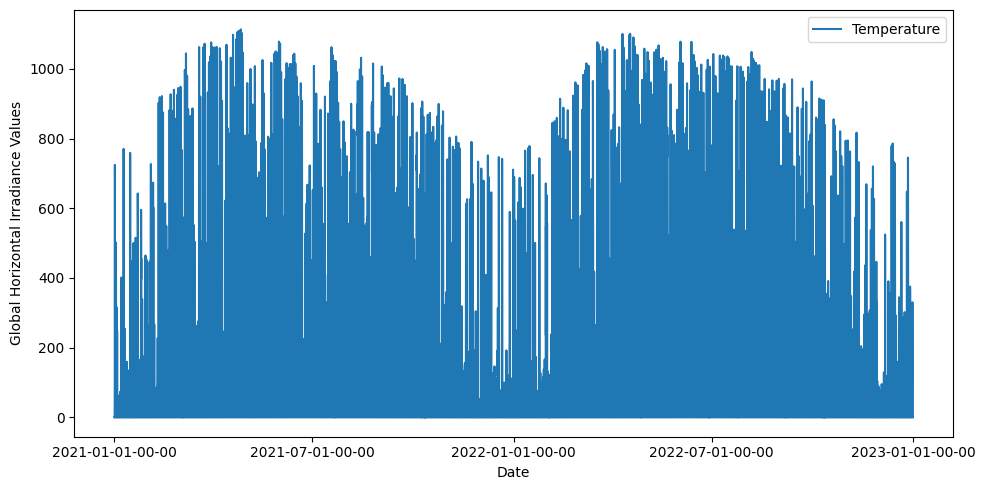

In [30]:
plt.figure(figsize=(10, 5))

plt.plot(df_2021_2022_Irr, label='Temperature')

# Set major x-axis locator to show only 4 dates
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=4))  # Force 4 labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d-%H-%M'))  # Format as 'YYYY-MM-DD-HH-mm'
plt.xlabel("Date")
plt.ylabel("Global Horizontal Irradiance Values")
plt.legend()
plt.tight_layout()
plt.show()

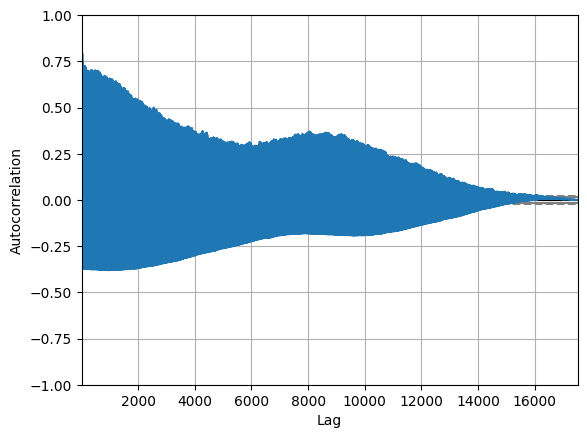

In [32]:
autocorrelation_plot(df_2021_2022_Irr)
plt.show()

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   G(i)   No. Observations:                17520
Model:                ARIMA(24, 1, 0)   Log Likelihood             -105055.299
Date:                Mon, 03 Feb 2025   AIC                         210160.599
Time:                        10:16:35   BIC                         210354.875
Sample:                    01-01-2021   HQIC                        210224.570
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1897      0.004    -52.039      0.000      -0.197      -0.183
ar.L2         -0.1406      0.004    -31.823      0.000      -0.149      -0.132
ar.L3         -0.1941      0.005    -38.815      0.0

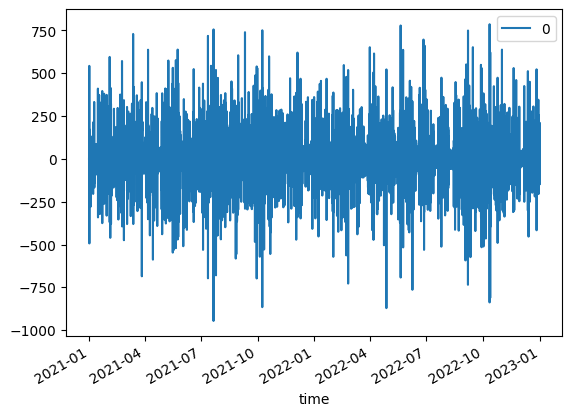

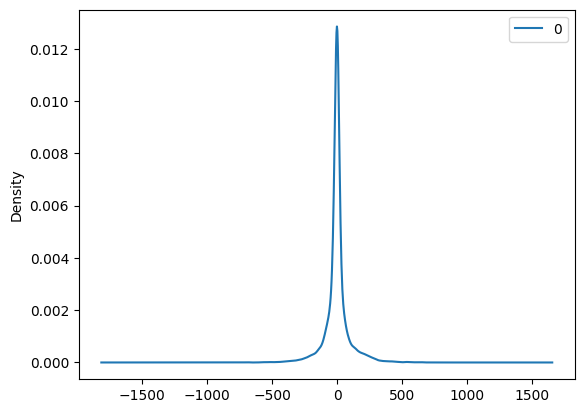

                  0
count  17520.000000
mean      -0.009864
std       97.322438
min     -945.941250
25%      -21.921776
50%       -1.413640
75%       15.919619
max      786.050240


In [33]:
# fit model
model_arima = ARIMA(df_2021_2022_Irr, order=(24,1,0))
model_fit = model_arima.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

In [34]:
# split into train and test sets
X = df_2021_2022_Irr.values
Y = df_2023_Irr.values
train_arima, test_arima = X, Y
history = [x for x in train_arima]
predictions = list()
rmse_per_prediction = []  # List to store RMSE per prediction

# Fit the initial ARIMA model only once
model_arima = ARIMA(history, order=(24,1,0))
model_fit = model_arima.fit()

# walk-forward validation
for t in range(len(test_arima)):
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test_arima[t]
	history.append(obs)

    # Instead of retraining, update the model
	model_fit = model_fit.append([obs], refit=False)

	# Compute RMSE for this single prediction
	single_rmse = np.sqrt((yhat - obs) ** 2)
	rmse_per_prediction.append(single_rmse)

	# Calculate completion percentage
	completion_rate = (t + 1) / len(test_arima) * 100
	
	print('predicted=%f, expected=%f, RMSE=%f | %f%% complete' % (yhat, obs, single_rmse, completion_rate))
	
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_arima, predictions))
print('Test RMSE: %.3f' % rmse)

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_14840\2603555361.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('predicted=%f, expected=%f, RMSE=%f | %f%% complete' % (yhat, obs, single_rmse, completion_rate))


predicted=8.441767, expected=0.000000, RMSE=8.441767 | 0.011416% complete
predicted=4.016165, expected=0.000000, RMSE=4.016165 | 0.022831% complete
predicted=-2.066687, expected=0.000000, RMSE=2.066687 | 0.034247% complete
predicted=-7.180242, expected=0.000000, RMSE=7.180242 | 0.045662% complete
predicted=-7.811374, expected=0.000000, RMSE=7.811374 | 0.057078% complete
predicted=-2.872269, expected=0.000000, RMSE=2.872269 | 0.068493% complete
predicted=2.968582, expected=0.000000, RMSE=2.968582 | 0.079909% complete
predicted=8.487133, expected=0.000000, RMSE=8.487133 | 0.091324% complete
predicted=18.578598, expected=21.010000, RMSE=2.431402 | 0.102740% complete
predicted=43.994615, expected=82.550000, RMSE=38.555385 | 0.114155% complete
predicted=105.264977, expected=88.060000, RMSE=17.204977 | 0.125571% complete
predicted=120.650661, expected=57.950000, RMSE=62.700661 | 0.136986% complete
predicted=100.599431, expected=85.910000, RMSE=14.689431 | 0.148402% complete
predicted=106.610

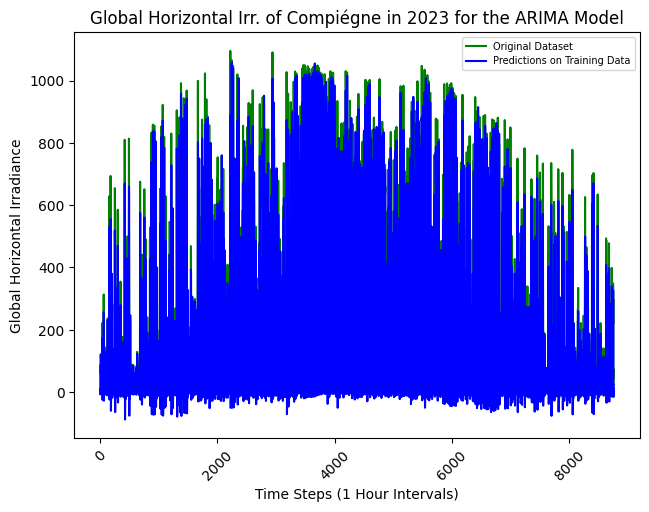

In [35]:
# Plot baseline and predictions

plt.plot(Y, 'g', label='Original Dataset')
plt.plot(predictions, 'b', label='Predictions on Training Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Global Horizontal Irradiance')
plt.title('Global Horizontal Irr. of Compiégne in 2023 for the ARIMA Model')
plt.show()

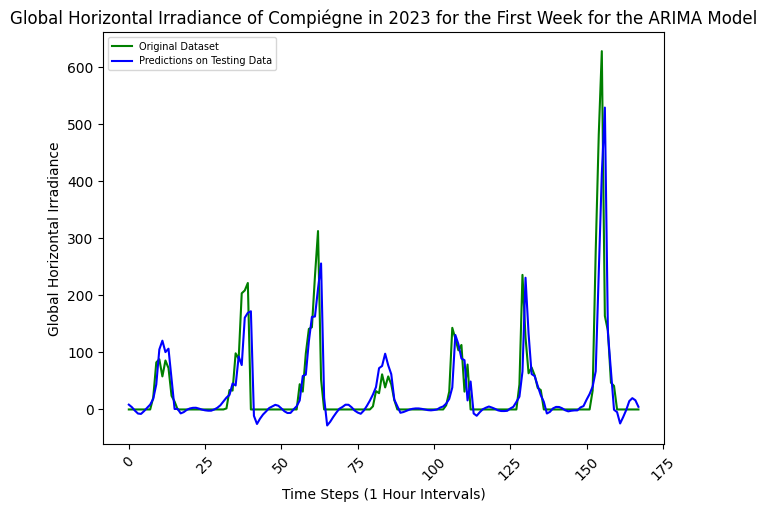

In [36]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(Y[:168], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(predictions[:168], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Global Horizontal Irradiance')
plt.title('Global Horizontal Irradiance of Compiégne in 2023 for the First Week for the ARIMA Model')
plt.show()

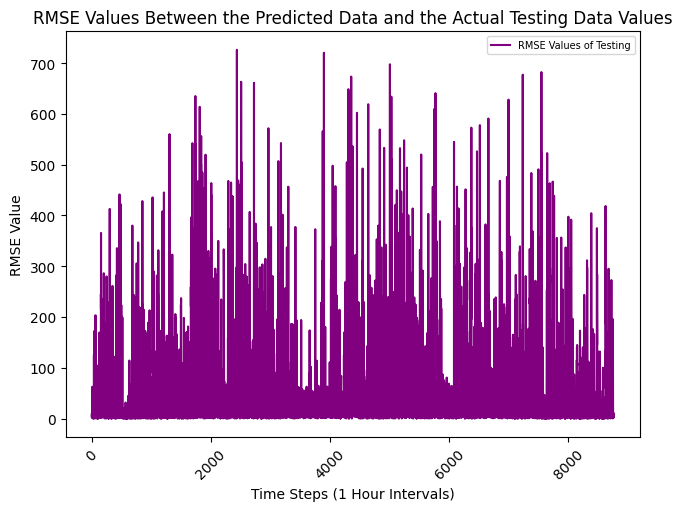

In [37]:
# Creating a graph for the RMSE values

plt.plot(rmse_per_prediction, 'purple', label='RMSE Values of Testing')
plt.legend(fontsize=7)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('RMSE Value')
plt.title('RMSE Values Between the Predicted Data and the Actual Testing Data Values')
plt.show()

In [38]:
# Finding the maximum and minimum RMSE values

maxRMSE_arima, minRMSE_arima = max(rmse_per_prediction), min(rmse_per_prediction)

print("Maximum RMSE for training data: ", maxRMSE_arima)
print("Minimum RMSE for training data: ", minRMSE_arima)

Maximum RMSE for training data:  [726.16423799]
Minimum RMSE for training data:  [0.00019791]


In [39]:
flat_list = [
    x
    for xs in rmse_per_prediction
    for x in xs
]

In [40]:
# Finding the worst guessed and best guessed weeks

window_size = 168  # Length of interval
rolling_avg = np.convolve(flat_list, np.ones(window_size)/window_size, mode='valid')

# Find the indices of the highest and lowest 168-element average
max_index = np.argmax(rolling_avg)  # Index where the highest average starts
min_index = np.argmin(rolling_avg)  # Index where the lowest average starts

# Extract the corresponding intervals
max_interval = flat_list[max_index:max_index + window_size]
min_interval = flat_list[min_index:min_index + window_size]

print(f"Highest 168-element average starts at index {max_index}, value: {np.max(rolling_avg):.3f}")
print(f"Lowest 168-element average starts at index {min_index}, value: {np.min(rolling_avg):.3f}")

Highest 168-element average starts at index 2432, value: 91.279
Lowest 168-element average starts at index 513, value: 12.112


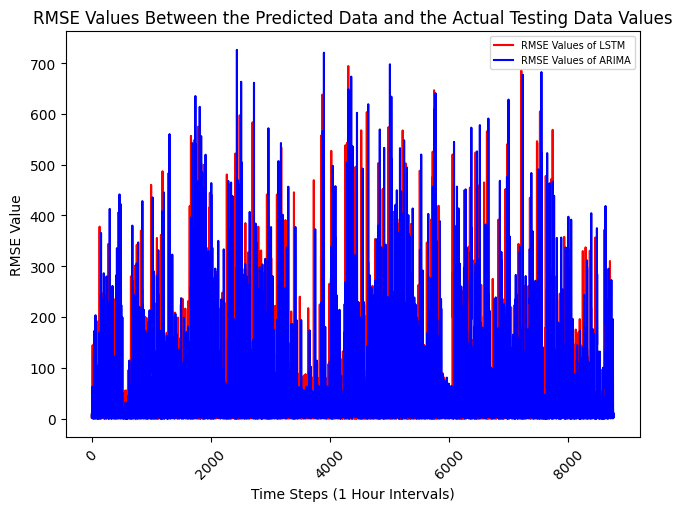

In [41]:
# Creating a graph for the RMSE values for both models

# For LSTM

plt.plot(testRMSE_each, 'r', label='RMSE Values of LSTM')
plt.legend(fontsize=7)

# For ARIMA

plt.plot(flat_list, 'b', label='RMSE Values of ARIMA')
plt.legend(fontsize=7)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('RMSE Value')
plt.title('RMSE Values Between the Predicted Data and the Actual Testing Data Values')
plt.show()

In [42]:
lstm_RMSE_avg = np.average(testRMSE_each)
arima_RMSE_avg = np.average(flat_list)

print("The average RMSE of the LSTM Model: ", '{0:.3f}'.format(lstm_RMSE_avg))
print("The average RMSE of the ARIMA Model: ", '{0:.3f}'.format(arima_RMSE_avg))

The average RMSE of the LSTM Model:  44.293
The average RMSE of the ARIMA Model:  52.265
